In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [3]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/main/data/solubility.npz",
    "solubility.npz",
)
with np.load("solubility.npz") as r:
    pos_data, neg_data = r["positives"], r["negatives"]

# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
full_data = tf.data.Dataset.from_tensor_slices((features, labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
print(N, "examples")
split = int(0.1 * N)
test_data = full_data.take(split).batch(16)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(16), nontest.skip(split).shuffle(
    1000
).batch(16)

18453 examples


In [9]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)
# reminder: the 16 means 16 filters in CNNs. Each filter is suppsoed to learn some feature

# now we move to convolutions and pooling
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           336       
                                                                 
 conv1d (Conv1D)             (None, 196, 16)           1296      
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 16)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 16)            784       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 16)            7

In [14]:
model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=0)

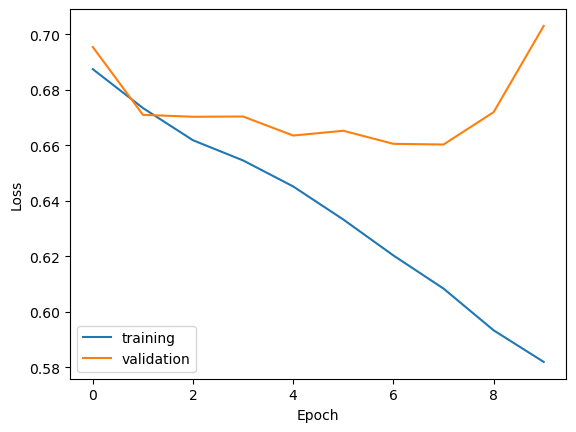

In [15]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [17]:
result.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# now we move to convolutions and pooling
# NOTE: Keras doesn't respect masking here
# I should switch to PyTorch.
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

# Here is the dropout
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 16)           336       
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 16)           1296      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 49, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 47, 16)            784       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 23, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 16)           

In [19]:
model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
923/923 [==============================] - 11s 9ms/step - loss: 0.6927 - accuracy: 0.5212 - val_loss: 0.6911 - val_accuracy: 0.5328
Epoch 2/10
923/923 [==============================] - 7s 8ms/step - loss: 0.6909 - accuracy: 0.5325 - val_loss: 0.6842 - val_accuracy: 0.5577
Epoch 3/10
923/923 [==============================] - 7s 7ms/step - loss: 0.6784 - accuracy: 0.5584 - val_loss: 0.6766 - val_accuracy: 0.5691
Epoch 4/10
923/923 [==============================] - 6s 7ms/step - loss: 0.6716 - accuracy: 0.5705 - val_loss: 0.6744 - val_accuracy: 0.5696
Epoch 5/10
923/923 [==============================] - 7s 7ms/step - loss: 0.6665 - accuracy: 0.5836 - val_loss: 0.6722 - val_accuracy: 0.5762
Epoch 6/10
923/923 [==============================] - 7s 8ms/step - loss: 0.6636 - accuracy: 0.5920 - val_loss: 0.6707 - val_accuracy: 0.5756
Epoch 7/10
923/923 [==============================] - 7s 7ms/step - loss: 0.6598 - accuracy: 0.5990 - val_loss: 0.6706 - val_accuracy: 0.5810
Epoch

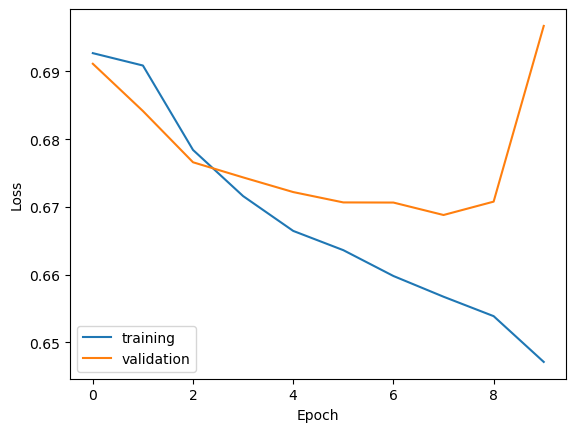

In [20]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

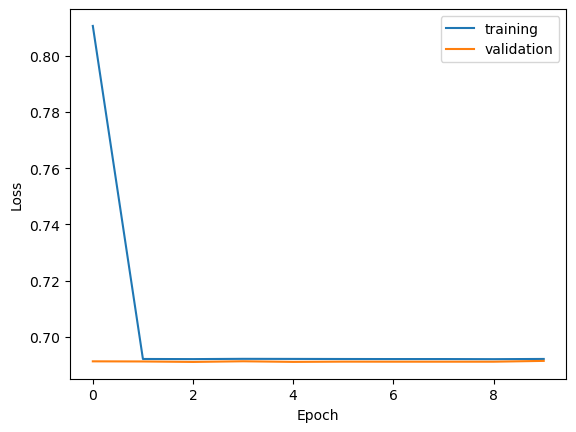

In [21]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated specially
model.add(
    tf.keras.layers.Embedding(
        input_dim=21, output_dim=16, mask_zero=True, input_length=pos_data.shape[-1]
    )
)

# now we move to convolutions and pooling
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=4))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# now we flatten to move to hidden dense layers.
# Flattening just removes all axes except 1 (and implicit batch is still in there as always!)

model.add(tf.keras.layers.Flatten())

# HERE IS THE REGULARIZATION:
model.add(tf.keras.layers.Dense(256, activation="relu", kernel_regularizer="l2"))
model.add(tf.keras.layers.Dense(64, activation="relu", kernel_regularizer="l2"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))


model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
result = model.fit(train_data, validation_data=val_data, epochs=10, verbose=0)

plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [22]:
help(np.outer)

Help on _ArrayFunctionDispatcher in module numpy:

outer(a, b, out=None)
    Compute the outer product of two vectors.
    
    Given two vectors `a` and `b` of length ``M`` and ``N``, repsectively,
    the outer product [1]_ is::
    
      [[a_0*b_0  a_0*b_1 ... a_0*b_{N-1} ]
       [a_1*b_0    .
       [ ...          .
       [a_{M-1}*b_0            a_{M-1}*b_{N-1} ]]
    
    Parameters
    ----------
    a : (M,) array_like
        First input vector.  Input is flattened if
        not already 1-dimensional.
    b : (N,) array_like
        Second input vector.  Input is flattened if
        not already 1-dimensional.
    out : (M, N) ndarray, optional
        A location where the result is stored
    
        .. versionadded:: 1.9.0
    
    Returns
    -------
    out : (M, N) ndarray
        ``out[i, j] = a[i] * b[j]``
    
    See also
    --------
    inner
    einsum : ``einsum('i,j->ij', a.ravel(), b.ravel())`` is the equivalent.
    ufunc.outer : A generalization to dimensi